Imports

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 60

from fisher_information import random_channel, exp_matrix

from qutip import *

import math
import numpy as np
import matplotlib.pyplot as plt

Autosaving every 60 seconds


States

In [ ]:
# Note: Nmax is now the number of states (dimension of HS) and the maximal number state is Nmax-1
Nmax = 100
ρ_vac = fock_dm(Nmax, 0)
ρ_fock = fock_dm(Nmax, 1)
ρ_coherent = coherent_dm(Nmax, 0.1)
ρ_thermal = thermal_dm(Nmax, 1.5)

In [ ]:
xvec = np.linspace(-5, 5, 200)

W_coherent = wigner(ρ_coherent, xvec, xvec)

W_thermal = wigner(ρ_thermal, xvec, xvec)

W_fock = wigner(ρ_fock, xvec, xvec)

In [ ]:
psi = (basis(10, 0) + basis(10, 3) + basis(10, 9)).unit()
W_Fock_sup = wigner(psi, xvec, xvec)

In [ ]:
# plot the results

fig, axes = plt.subplots(1, 4, figsize=(16, 3))

cont0 = axes[0].contourf(xvec, xvec, W_coherent, 100, cmap=wigner_cmap(W_coherent))
cb0 = fig.colorbar(cont0, ax=axes[0])
lbl0 = axes[0].set_title("Coherent state")

cont1 = axes[1].contourf(xvec, xvec, W_thermal, 100, cmap=wigner_cmap(W_thermal))
cb1 = fig.colorbar(cont1, ax=axes[1])
lbl1 = axes[1].set_title("Thermal state")

cont2 = axes[2].contourf(xvec, xvec, W_fock, 100, cmap=wigner_cmap(W_fock))
cb2 = fig.colorbar(cont2, ax=axes[2])
lbl2 = axes[2].set_title("Fock state")

cont3 = axes[3].contourf(xvec, xvec, W_Fock_sup, 100, cmap=wigner_cmap(W_Fock_sup))
fig.colorbar(cont3, ax=axes[3])
axes[3].set_title("0 + 3 + 9 Fock states")

plt.show()

In [ ]:
U = displace(Nmax, 2) * squeeze(Nmax, 1j)
ρ_SMSV = U * ρ_vac * U.dag()

W = wigner(ρ_SMSV, xvec, xvec)

In [ ]:
cont = plt.contourf(xvec, xvec, W, 100, cmap=wigner_cmap(W))
plt.colorbar(cont)
plt.show()

Fidelity has some numerical error

In [ ]:
states = [ρ_vac, ρ_fock, ρ_SMSV, ρ_thermal, ρ_coherent]
for ρ in states:
    print(fidelity(ρ, ρ))

Numerical error versus truncation number

In [ ]:
Nmaxs = [2, 5, 10, 20, 50, 100, 200, 300]

state_fns = dict(
    coherent=lambda N: coherent_dm(N, 0.5),
    thermal=lambda N: thermal_dm(N, 1.5),
    SMSV=lambda N: squeeze(N, 0.4j) * fock_dm(N, 0) * squeeze(N, 0.4j).dag(),
)

for label, state_fn in state_fns.items():
    print(label)
    for Nmax in Nmaxs:
        ρ = state_fn(Nmax)
        print(Nmax, fidelity(ρ, ρ))

In [ ]:
state = coherent_dm(Nmax, 0.5)

In [ ]:
# state.data()
state.full()

Doubles and longs

In [48]:
np.finfo(np.float64)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [47]:
np.finfo(np.clongdouble)

/tmp/ipykernel_15641/1330765058.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.finfo(np.float)


finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [45]:
np.finfo(np.clongdouble).precision

18

Eigenvalues

In [ ]:
state = coherent_dm(100, 1.5)
state.eigenenergies()

In [ ]:
# evals are still negative?
state.trunc_neg().eigenenergies()

Cat state

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

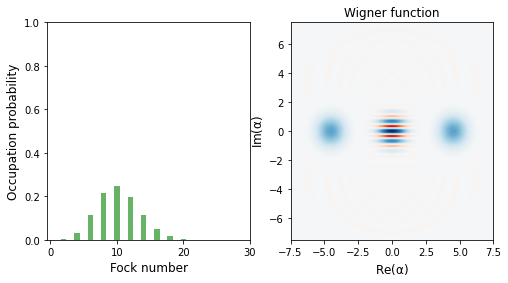

In [53]:
Nmax = 30
α = 3.2
ρ_cat_even = (coherent(Nmax, α) + coherent(Nmax, -α)).unit()
plot_wigner_fock_distribution(ρ_cat_even)

ρ_cat_odd = (coherent(Nmax, α) - coherent(Nmax, -α)).unit()
plot_wigner_fock_distribution(ρ_cat_odd)

In [ ]:
# TODO: implement loss (using BS below?) and then show that the wigner negativity disappears

### Choi rep

Pure case diverges

In [43]:
# Can take O(10) seconds

Nmax = 20
# maximally_entangled_unnormalised_state in density matrix form
ρ = ket2dm(sum(tensor(fock(Nmax, i), fock(Nmax, i)) for i in range(Nmax)))
# display(ρ)

Dtensor = lambda α: tensor(displace(Nmax, α), identity(Nmax))
subchannel = lambda ρ0, α: (Dtensor(α) * ρ0 * Dtensor(α).dag()).full()

σ = 0.01
ρ1 = Qobj(random_channel(ρ, σ, subchannel), dims=ρ.dims)
choi1 = ρ1
choi_inv = choi1.inv()

LinAlgError: Singular matrix

In [36]:
σ = 0.01
δσ = 0.001
# restoring the dimensions correctly
ρ1 = Qobj(random_channel(ρ, σ, subchannel), dims=ρ.dims)
ρ2 = Qobj(random_channel(ρ, σ + δσ, subchannel), dims=ρ.dims)

choi1 = ρ1
choi2 = ρ2
δchoi = choi2 - choi1
choi_dot = δchoi / δσ

choi_inv = choi1.inv()

# ptrace keeps the systems with the given indices
RLD_UB = ((choi_dot * choi_inv * choi_dot).ptrace(0)).norm()

LinAlgError: Singular matrix

Loss on $\ket{\mathbb{I}}$, UB also diverges

In [44]:
Nmax = 20

c = lambda n, k, η: math.sqrt(np.math.comb(n, k) * (1 - η) ** (n - k) * η**k)

η = 0.1
# \ket{𝕀} after loss
ρ = ket2dm(
    sum(
        c(n, k, η) * tensor(fock(Nmax, n - k), fock(Nmax, n))
        for n in range(Nmax)
        for k in range(n + 1)
    )
)

Dtensor = lambda α: tensor(displace(Nmax, α), identity(Nmax))
subchannel = lambda ρ0, α: (Dtensor(α) * ρ0 * Dtensor(α).dag()).full()

σ = 0.01
ρ1 = Qobj(random_channel(ρ, σ, subchannel), dims=ρ.dims)
choi1 = ρ1
choi_inv = choi1.inv()

LinAlgError: Singular matrix

Correct loss formula: 

In [2]:
Nmax = 20

c = lambda n, k, η: math.sqrt(np.math.comb(n, k) * (1 - η) ** (n - k) * η**k)

η = 0.1
# DM for 𝕀 after loss
ρ = sum(
    c(n, k, η) * tensor(fock_dm(Nmax, n - k), fock_dm(Nmax, n))
    for n in range(Nmax)
    for k in range(n + 1)
)

Dtensor = lambda α: tensor(displace(Nmax, α), identity(Nmax))
subchannel = lambda ρ0, α: (Dtensor(α) * ρ0 * Dtensor(α).dag()).full()

σ = 0.01
ρ1 = Qobj(random_channel(ρ, σ, subchannel), dims=ρ.dims)
choi1 = ρ1
choi_inv = choi1.inv()

LinAlgError: Singular matrix

Loss beamsplitter

TODO: implement loss binomial in tensor form

Or, instead of a loss binomial, just use a beamsplitter and partial trace directly?

In [ ]:
def loss_beamsplitter(ρ, η):
    ρ_joint = tensor(ρ, fock_dm(Nmax, 0))
    θ = np.arccos(np.sqrt(1 - η))
    exponent = (
        1j
        * θ
        * (tensor(create(Nmax), destroy(Nmax)) - tensor(destroy(Nmax), create(Nmax)))
    )
    # memory issues?
    # TODO: check that this is the correct form of the exponential of the tensor product
    # TODO: search QuTiP for loss model (master eq) to check against
    U = Qobj(exp_matrix(exponent, truncation=30), dims=exponent.dims)
    return (U * ρ_joint * U.dag()).ptrace(0)

In [ ]:
Nmax = 10
# TODO: fix normalisation issue, original probability also grows? Isn't just a norm issue
loss_beamsplitter(fock_dm(Nmax, 3), 0.1)

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[1.23004596e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.81305876e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.94007422e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.35710688e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+

In [ ]:
from fisher_information import loss_binomial

Nmax = 32
loss_binomial(fock_dm(Nmax, 3).full(), 0.1).diagonal()

array([0.001+0.j, 0.027+0.j, 0.243+0.j, 0.729+0.j, 0.   +0.j, 0.   +0.j,
       0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
       0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
       0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
       0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
       0.   +0.j, 0.   +0.j])